In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, plot_roc_curve

from sklearn.inspection import PartialDependenceDisplay

import warnings
warnings.filterwarnings('ignore')

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenueThe goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue

## 1.  Load data

In [2]:
data = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/conversion_data.csv')

In [3]:
data.head(3)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


## 2.  Data Cleaning

### 2.1 Remove outliers in 'age'

We notice that age has the outlayer like 123.

Therefore, we need to check the distribution of age to confirm how to deal with outliers

<AxesSubplot:xlabel='age', ylabel='Count'>

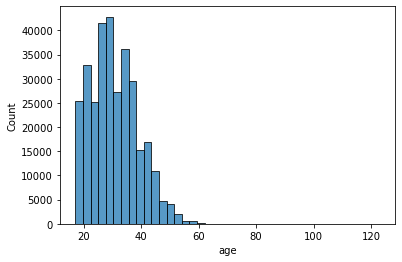

In [6]:
sns.histplot(data['age'], bins = 40)

In [7]:
older_than_60 = data[(data['age'] > 60)]['age'] 
older_than_60.shape

(237,)

<AxesSubplot:xlabel='age', ylabel='Count'>

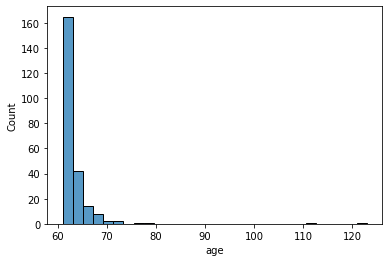

In [8]:
sns.histplot(older_than_60, bins = 30)

From the histgram of age above, we notice that customers with an age over 60 are pretty rare.
Then we plot a futher histgram to detect the outlier's distribution. We can see that age exceed 65 can be taken as outliers. We decide to remove them.

In [9]:
clean_data = data[(data['age'] <= 65)] 

<AxesSubplot:xlabel='age', ylabel='Count'>

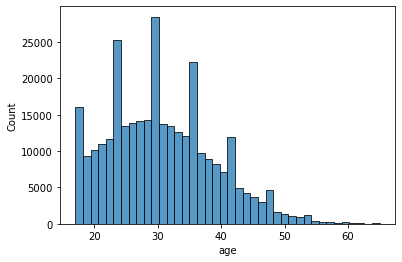

In [10]:
sns.histplot(clean_data['age'], bins = 40)

### 2.2 Explore Country distribution

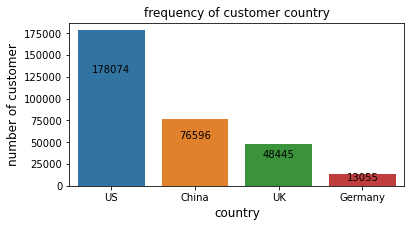

In [11]:
country_type = clean_data['country'].value_counts()

fig, ax = plt.subplots(figsize=(6, 3))

x_axis = country_type.index.tolist()
y_axis = country_type.values.tolist()

g = sns.barplot(x = x_axis, y = y_axis)

plt.title('frequency of customer country')
plt.ylabel('number of customer', fontsize = 12)
plt.xlabel('country', fontsize = 12)
for p in g.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h*0.75)
    text = f'{h:0.0f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

plt.show()

The website has the most customer in US. It also has lots of customer in China.

However, customer in Germany is extramelly low.

### 2.3 Explore Source distribution

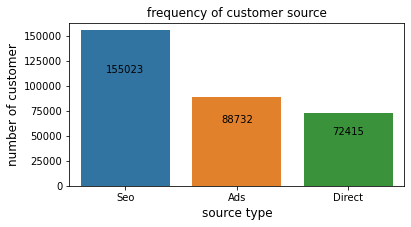

In [12]:
source_type = clean_data['source'].value_counts()

fig, ax = plt.subplots(figsize=(6, 3))

x_axis = source_type.index.tolist()
y_axis = source_type.values.tolist()

g = sns.barplot(x = x_axis, y = y_axis)

g.set_title('frequency of customer source')
g.set_xlabel('source type', fontsize = 12)
g.set_ylabel('number of customer', fontsize = 12)

for p in g.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h*0.75)
    text = f'{h:0.0f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

plt.show()

Clicking on search results is the most common way to reach out the website.

### 2.3 Explore old and new user type distribution

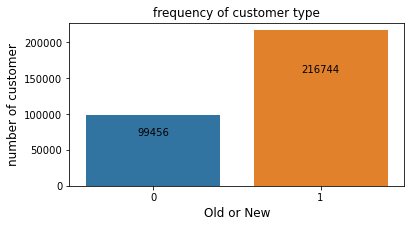

In [13]:
customer_type = data['new_user'].value_counts()

fig, ax = plt.subplots(figsize=(6, 3))

x_axis = customer_type.index.tolist()
y_axis = customer_type.values.tolist()

g = sns.barplot(x = x_axis, y = y_axis)

plt.title('frequency of customer type')
plt.ylabel('number of customer', fontsize = 12)
plt.xlabel('Old or New', fontsize = 12)
for p in g.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h*0.75)
    text = f'{h:0.0f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')

plt.show()

More than 2/3 of the visits came from new customers. It also indicates that the retation rate of the website in old customers is relatively low.

## 3. Data Visualization

### 3.1 covert rate vs country

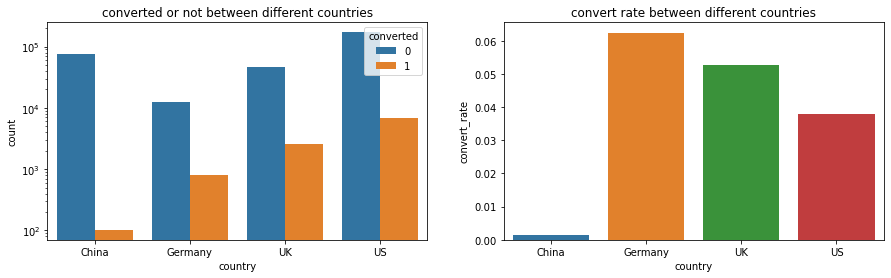

In [14]:
grouped_count = clean_data.groupby(['country', 'converted']).size().reset_index()
grouped_count.columns = ['country', 'converted', 'count']

grouped_convert_rate = clean_data[['country', 'converted']].groupby('country').mean().reset_index()
grouped_convert_rate.columns = ['country', 'convert_rate']

fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex = True)

sns.barplot(data = grouped_count, x ='country', hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different countries')

sns.barplot(data = grouped_convert_rate, x ='country', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different countries')

plt.show()

China has an extremely low convert rate which looks abmormal and need more reseach.

Germany has the highest convert rate but the customer size is very low.

### 3.2 covert rate vs customer source

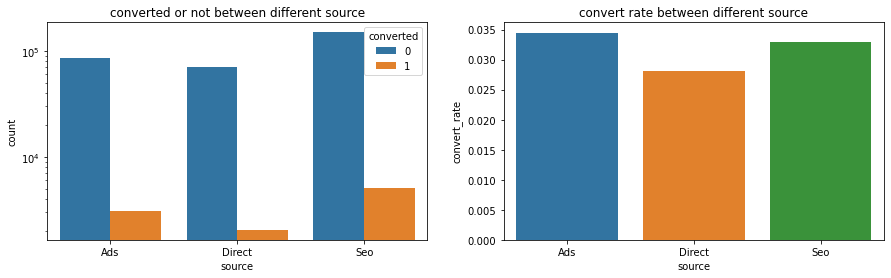

In [15]:
grouped_count = clean_data.groupby(['source', 'converted']).size().reset_index()
grouped_count.columns = ['source', 'converted', 'count']

grouped_convert_rate = clean_data[['source', 'converted']].groupby('source').mean().reset_index()
grouped_convert_rate.columns = ['source', 'convert_rate']

fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex = True)

sns.barplot(data = grouped_count, x ='source', hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different source')

sns.barplot(data = grouped_convert_rate, x ='source', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different source')

plt.show()

Ads and Seo are more more effective in convert rate, but the difference between three sources are not large.

### 3.3 covert rate vs new and old customers

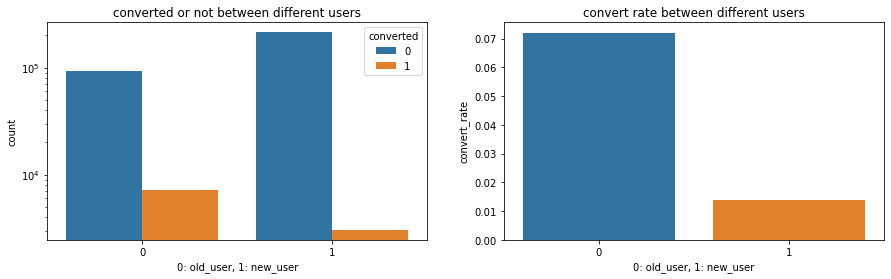

In [16]:
grouped_count = clean_data.groupby(['new_user', 'converted']).size().reset_index()
grouped_count.columns = ['0: old_user, 1: new_user', 'converted', 'count']

grouped_convert_rate = clean_data[['new_user', 'converted']].groupby('new_user').mean().reset_index()
grouped_convert_rate.columns = ['0: old_user, 1: new_user', 'convert_rate']

fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex = True)

sns.barplot(data = grouped_count, x ='0: old_user, 1: new_user', hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different users')

sns.barplot(data = grouped_convert_rate, x ='0: old_user, 1: new_user', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different users')

plt.show()

Old users have an absolute high convert rate.

The website has more new users but their convert rate is not efficient

### 3.4 covert rate vs age

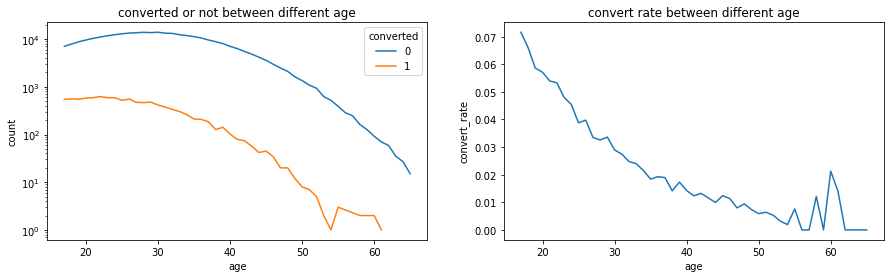

In [17]:
grouped_count = clean_data.groupby(['age', 'converted']).size().reset_index()
grouped_count.columns = ['age', 'converted', 'count']

grouped_convert_rate = clean_data[['age', 'converted']].groupby('age').mean().reset_index()
grouped_convert_rate.columns = ['age', 'convert_rate']

fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex = True)

sns.lineplot(data = grouped_count, x ='age', hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different age')

sns.lineplot(data = grouped_convert_rate, x ='age', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different age')

plt.show()

The website is more popular among young users than the olde ones.

### 3.5 covert rate vs visited page

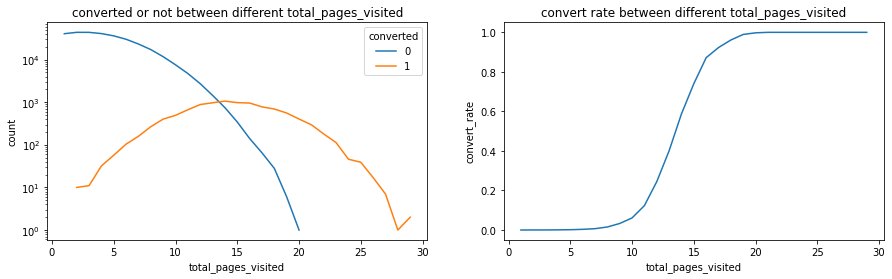

In [18]:
grouped_count = clean_data.groupby(['total_pages_visited', 'converted']).size().reset_index()
grouped_count.columns = ['total_pages_visited', 'converted', 'count']

grouped_convert_rate = clean_data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
grouped_convert_rate.columns = ['total_pages_visited', 'convert_rate']

fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex = True)

sns.lineplot(data = grouped_count, x ='total_pages_visited', hue='converted', y = 'count', ax = ax[0])
ax[0].set_yscale("log")
ax[0].set_title('converted or not between different total_pages_visited')

sns.lineplot(data = grouped_convert_rate, x ='total_pages_visited', y = 'convert_rate', ax = ax[1])
ax[1].set_title('convert rate between different total_pages_visited')

plt.show()

The more page you visit, the more likely you will buy something in the website.

## 4. Model Fitting

### 4.1 Prepare Data 

In [19]:
# create dummy variables for category features.
data_with_dummy = pd.get_dummies(clean_data, columns = ['country', 'source'], drop_first = True)
data_with_dummy.head(3)

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1


In [20]:
# split original data set into train and test:
features_with_dummy = data_with_dummy.columns[:3].tolist() + data_with_dummy.columns[4:].tolist()

X_train, X_test, y_train, y_test = train_test_split(data_with_dummy[features_with_dummy], 
                                                    data_with_dummy['converted'], 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [21]:
features_with_dummy

['age',
 'new_user',
 'total_pages_visited',
 'country_Germany',
 'country_UK',
 'country_US',
 'source_Direct',
 'source_Seo']

This is a classification problem, we can use both Logist Regression and Decision Tree/Random Forest to fit the model.

### 4.1 LogisticRegression

In [ ]:
# z = w0 + w1*x1 + w2*x2 + w3*x3 + w4*x4
# y = 1/(1 + e^(-z))

In [39]:
logreg = LogisticRegression(random_state = 0).fit(X_train, y_train)

In [23]:
model = logreg
train_con_matrix = confusion_matrix(y_train, model.predict(X_train))
print('train matrix: \n', train_con_matrix)
print('train accuracy:', round(accuracy_score(y_train, model.predict(X_train)),4))

test_con_matrix = confusion_matrix(y_test, model.predict(X_test))
print('\n test matrix: \n', test_con_matrix)
print('test accuracy:', round(accuracy_score(y_test, model.predict(X_test)), 4))

train matrix: 
 [[243856    969]
 [  2492   5619]]
train accuracy: 0.9863

 test matrix: 
 [[60899   248]
 [  671  1416]]
test accuracy: 0.9855


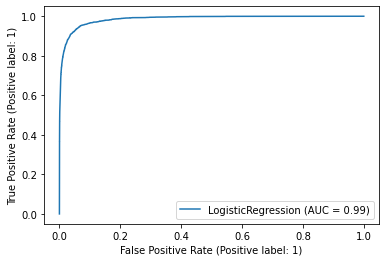

In [24]:
plot_roc_curve(logreg, X_test, y_test) 

In [40]:
logreg.intercept_[0]

-10.241848929083677

In [45]:
pd.DataFrame(logreg.coef_[0], features_with_dummy, )

,0
age,-0.072160
new_user,-1.796807
total_pages_visited,0.767015
country_Germany,3.554448
country_UK,3.281705
country_US,2.996278
source_Direct,-0.059745
source_Seo,-0.008625


In [47]:
import math
pow(math.e,logreg.coef_[0])

array([ 0.93038161,  0.16582747,  2.15332985, 34.96850515, 26.62113292,
       20.01091543,  0.94200505,  0.99141205])

### 4.2 DecisionTreeClassifier

In [26]:
fullClassTree = DecisionTreeClassifier(random_state=1, max_depth = 5)
fullClassTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [27]:
model = fullClassTree
train_con_matrix = confusion_matrix(y_train, model.predict(X_train))
print('train matrix: \n', train_con_matrix)
print('train accuracy:', round(accuracy_score(y_train, model.predict(X_train)),4))

test_con_matrix = confusion_matrix(y_test, model.predict(X_test))
print('\n test matrix: \n', test_con_matrix)
print('test accuracy:', round(accuracy_score(y_test, model.predict(X_test)), 4))

train matrix: 
 [[243790   1035]
 [  2641   5470]]
train accuracy: 0.9855

 test matrix: 
 [[60850   297]
 [  741  1346]]
test accuracy: 0.9836


### 4.3 RandomForestClassifier

random froest requeires very little time to optimize it, and it's strong with outlier, irrelevant variable, continuous and discrete variables.

In [28]:
rf_reg = RandomForestClassifier(max_features=3)
rf_reg.fit(X_train, y_train)

RandomForestClassifier(max_features=3)

In [29]:
model = rf_reg
train_con_matrix = confusion_matrix(y_train, model.predict(X_train))
print('train matrix: \n', train_con_matrix)
print('train accuracy:', round(accuracy_score(y_train, model.predict(X_train)),4))

test_con_matrix = confusion_matrix(y_test, model.predict(X_test))
print('\n test matrix: \n', test_con_matrix)
print('test accuracy:', round(accuracy_score(y_test, model.predict(X_test)), 4))

train matrix: 
 [[244078    747]
 [  2175   5936]]
train accuracy: 0.9884

 test matrix: 
 [[60824   323]
 [  715  1372]]
test accuracy: 0.9836


Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

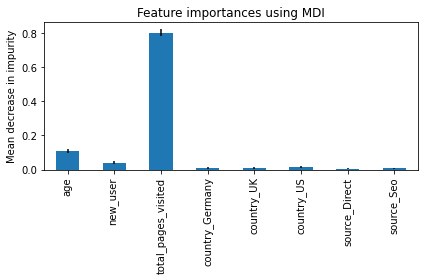

In [30]:
import time
rf_reg_importances = pd.Series(rf_reg.feature_importances_, index=features_with_dummy)
std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
elapsed_time = time.time()

fig, ax = plt.subplots()
rf_reg_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”. People visit many pages cause they already want to buy. Also, in order to buy you have to click on multiple pages. Therefore, we need further exploratory analysis besides page visited.

### 4.4 Model Optimalization

we can fit a model without the feature of page visited

In [31]:
features_with_dummy_modify = data_with_dummy.columns[:2].tolist() + data_with_dummy.columns[4:].tolist()

In [32]:
rf_reg_modify = RandomForestClassifier(max_features=3)
X_train_modify =  X_train[features_with_dummy_modify]
rf_reg_modify.fit(X_train_modify, y_train)

RandomForestClassifier(max_features=3)

In [33]:
X_test_modify =  X_test[features_with_dummy_modify]

In [34]:
model = rf_reg_modify
train_con_matrix = confusion_matrix(y_train, model.predict(X_train_modify))
print('train matrix: \n', train_con_matrix)
print('train accuracy:', round(accuracy_score(y_train, model.predict(X_train_modify)),4))

test_con_matrix = confusion_matrix(y_test, model.predict(X_test_modify))
print('\n test matrix: \n', test_con_matrix)
print('test accuracy:', round(accuracy_score(y_test, model.predict(X_test_modify)), 4))

train matrix: 
 [[244825      0]
 [  8111      0]]
train accuracy: 0.9679

 test matrix: 
 [[61147     0]
 [ 2087     0]]
test accuracy: 0.967


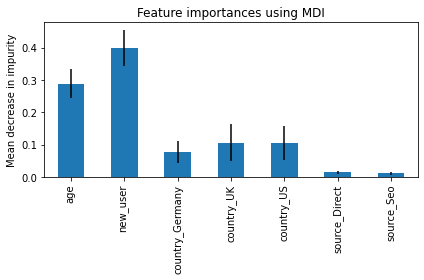

In [35]:
rf_reg_importances = pd.Series(rf_reg_modify.feature_importances_, index=features_with_dummy_modify)
std = np.std([tree.feature_importances_ for tree in rf_reg_modify.estimators_], axis=0)
elapsed_time = time.time()

fig, ax = plt.subplots()
rf_reg_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Therefore new_user is another most important feature except pages.

Source is not important at all

Except for feature importance, we can also find key features which affect the customer converts or not by plotting the decision tree.

no display found. Using non-interactive Agg backend


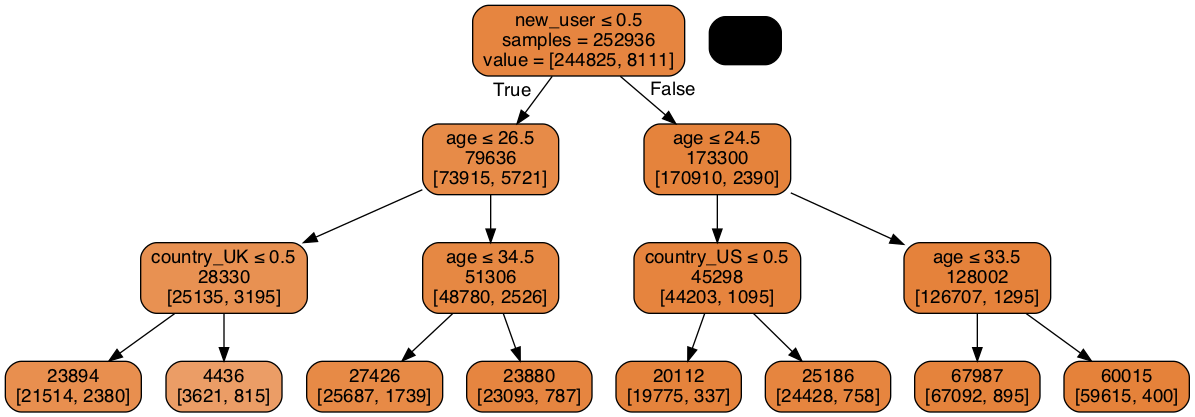

In [36]:
from dmba import plotDecisionTree

three_level_Tree = DecisionTreeClassifier(random_state=1, max_depth = 3)
three_level_Tree.fit(X_train_modify, y_train)
plotDecisionTree(three_level_Tree, feature_names = X_train_modify.columns)